<a href="https://www.kaggle.com/code/mikedelong/eda-with-map?scriptVersionId=137043788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/los-angeles-crime-dataset-2020-present/Crime_Data_from_2020_to_Present.csv', 
                 parse_dates=['Date Rptd', 'DATE OCC']).drop(columns=['DR_NO'])
df.sample(n=7)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
108384,2020-08-07,2020-08-07,1300,16,Foothill,1617,1,761,BRANDISH WEAPON,2004 1212 1822 0334 1402,...,IC,Invest Cont,761.0,998.0,NaN,NaN,ORO VISTA,GROVE,0.0000,0.0000
704074,2023-05-09,2023-03-17,2014,14,Pacific,1472,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,IC,Invest Cont,745.0,NaN,NaN,NaN,6600 ESPLANADE ST,NaN,33.9618,-118.4510
633035,2022-10-05,2022-10-05,2130,10,West Valley,1024,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),1822 0325 0216,...,IC,Invest Cont,442.0,NaN,NaN,NaN,18800 SHERMAN WY,NaN,34.2011,-118.5426
699407,2023-01-03,2023-01-03,845,5,Harbor,532,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),1822 0385 0344,...,IC,Invest Cont,420.0,NaN,NaN,NaN,1000 RONAN AV,NaN,33.7824,-118.2719
354132,2021-07-07,2021-07-07,1645,8,West LA,885,1,440,THEFT PLAIN - PETTY ($950 & UNDER),1822 0344,...,IC,Invest Cont,440.0,NaN,NaN,NaN,10400 W PICO BL,NaN,34.0460,-118.4176
612181,2022-05-15,2022-05-13,1000,11,Northeast,1161,2,624,BATTERY - SIMPLE ASSAULT,0416,...,IC,Invest Cont,624.0,NaN,NaN,NaN,1200 N KENMORE AV,NaN,34.0934,-118.2974
376443,2021-05-21,2021-05-21,1830,2,Rampart,202,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",1202 0329 1822 0202 1307,...,IC,Invest Cont,740.0,NaN,NaN,NaN,4200 LOCKWOOD AV,NaN,34.0887,-118.2850


In [2]:
df.columns

Index(['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No',
       'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd',
       'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2',
       'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Vict Age', ylabel='Density'>

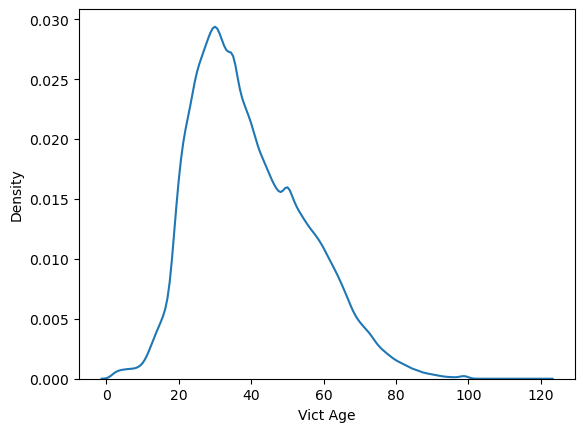

In [3]:
# let's look at some distributions
%matplotlib inline
from seaborn import kdeplot
# we need to drop ages = 0 to filter out unknowns
kdeplot(data=df[df['Vict Age'] > 0], x='Vict Age')

In [4]:
from folium import Map
from folium import Marker

sample_size = 1000
sample_df = df.sample(sample_size)

# for some reason we have to fudge the center a little
lon_fudge = -0.5
location_map = Map(location=[sample_df['LAT'].mean(), sample_df['LON'].mean() + lon_fudge], zoom_start=10)
for index, row in sample_df.iterrows():
    popup = '{}/{}/{}:{}'.format(row['LOCATION'], row['AREA NAME'], row['Crm Cd Desc'], row['Status'])
    Marker([row['LAT'], row['LON']], popup=popup).add_to(parent=location_map)

location_map

In [5]:
df.shape

(752911, 27)

In [6]:
df['Crm Cd'].nunique()

138

We have 138 codes; clearly we can't make sense of a pie with that many slices, so let's look at the top ten or so

In [7]:
crime_code_value_counts = df['Crm Cd Desc'].value_counts()
code_df = pd.DataFrame(data={'Code': crime_code_value_counts.index, 'Count': crime_code_value_counts.values}).reset_index(drop=True)
code_df.head(10)

,Code,Count
0,VEHICLE - STOLEN,80439
1,BATTERY - SIMPLE ASSAULT,59630
2,THEFT OF IDENTITY,48645
3,BURGLARY FROM VEHICLE,46526
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",46157
5,BURGLARY,45717
6,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",43149
7,THEFT PLAIN - PETTY ($950 & UNDER),38510
8,INTIMATE PARTNER - SIMPLE ASSAULT,37947
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),29310


In [8]:
import plotly.express as px
code_df.loc[code_df['Count'] < 15000, 'Code'] = 'Other' # we have too many codes so let's apply a threshold
px.pie(code_df, names='Code', values='Count').show()

In [9]:
# Surely the areas are shaped so the crime is roughly the same in each one; right?
area_value_counts = df['AREA NAME'].value_counts()
area_df = pd.DataFrame(data={'Area': area_value_counts.index, 'Count': area_value_counts.values}).reset_index(drop=True)
px.pie(area_df, names='Area', values='Count').show()